In [1]:
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize, LogNorm
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
import scqubits
from tqdm import tqdm
from IPython.display import clear_output
import qutip
from functools import partial
import matplotlib
from CoupledQuantumSystems.drive import *
from scipy.optimize import minimize

from CoupledQuantumSystems.noise import first_order_derivative,second_order_derivative,get_frequency,diel_spectral_density,one_over_f_spectral_density,T_phi
from CoupledQuantumSystems.IFQ import gfIFQ
from CoupledQuantumSystems.evo import ODEsolve_and_post_process

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\varphi$', ylabel='Re $\\psi_j(\\varphi)$,  energy [GHz]'>)

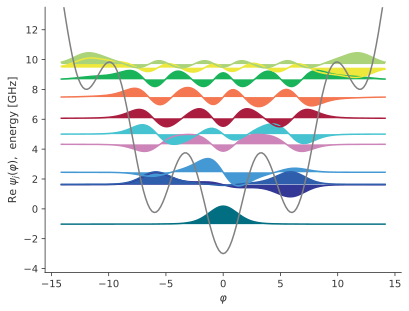

In [7]:
EJ = 3
EC = EJ/4
EL = EJ/20.5

qbt = gfIFQ(EJ = EJ,EC = EC, EL = EL, flux = 0,truncated_dim=30)
e_ops = [qutip.basis(qbt.truncated_dim, i)*qutip.basis(qbt.truncated_dim, i).dag() for i in range(10)]

element = np.abs(qbt.fluxonium.matrixelement_table('n_operator',evals_count=3)[1,2]) 
freq = (qbt.fluxonium.eigenvals()[2]-qbt.fluxonium.eigenvals()[1]) * 2 * np.pi
qbt.fluxonium.plot_wavefunction(which=[0,1,2,3,4,5,6,7,8,9,10])


In [8]:
import json
t_tot_array = np.linspace(5,100,96)
folder_name = 'denser_x_gate_sweep'
# load all results
results = []
for t_tot_idx in range(len(t_tot_array)):
    with open(f"denser_x_gate_sweep/result_t_tot_{t_tot_idx}.json", "r") as f:
        results.append(json.load(f))


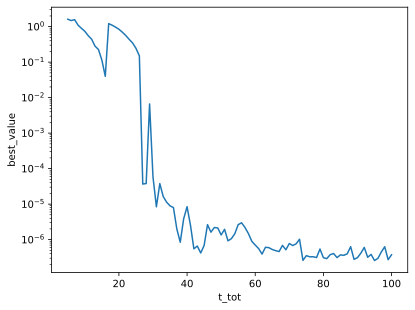

In [9]:
# Plot best_value as a function of t_tot
plt.plot(t_tot_array, [result['best_value'] for result in results])
plt.xlabel('t_tot')
plt.ylabel('best_value')
plt.yscale('log')
plt.show()

In [10]:
state_0_dressed = qutip.basis(qbt.truncated_dim, 1)
state_1_dressed = qutip.basis(qbt.truncated_dim, 2)
state_plus_X_dressed = (state_0_dressed +  state_1_dressed).unit()
state_minus_X_dressed = (state_0_dressed - state_1_dressed).unit()
state_plus_Y_dressed = (state_0_dressed + 1j * state_1_dressed).unit()
state_minus_Y_dressed = (state_0_dressed - 1j * state_1_dressed).unit()

initial_states  = [
                   state_0_dressed,
                   state_1_dressed,
                   state_plus_X_dressed,
                   state_minus_X_dressed,
                   state_plus_Y_dressed,
                   state_minus_Y_dressed
                   ]

temp_in_mK = 20
Q_cap = 1e5
one_over_f_flux_noise_amplitude = 1e-6
T1_cops = qbt.get_T1_c_ops(temp_in_mK,
                        Q_cap,
                        one_over_f_flux_noise_amplitude)

 /home/kai/miniconda3/envs/dynamiqs/lib/python3.10/site-packages/CoupledQuantumSystems/IFQ.py: 63

In [12]:
qbt.fluxonium.truncated_dim

30

In [11]:
Tphi_cops = qbt.get_Tphi_c_ops(one_over_f_flux_noise_amplitude)

IndexError: index 20 is out of bounds for axis 0 with size 20

In [8]:

c_ops= T1_cops + Tphi_cops
e_ops = [qutip.ket2dm(qutip.basis(qbt.truncated_dim, i)) for i in range(qbt.truncated_dim)]

def truncate_to_computational_and_renormaize(state,i,j):
    if state.isket:
        state = qutip.ket2dm(state)
    arr = state.full()
    arr= arr[[i, j], :][:, [i, j]]
    dm = qutip.Qobj(arr)
    dm = dm/dm.tr()
    return dm
def truncate_to_computational_without_renormaize(state,i,j):
    if state.isket:
        state = qutip.ket2dm(state)
    arr = state.full()
    arr= arr[[i, j], :][:, [i, j]]
    dm = qutip.Qobj(arr)
    return dm
zero = qutip.basis(2, 0)
one = qutip.basis(2, 1)
states_ideal  = [zero,
                one,
                (zero +  one).unit(),
                (zero - one).unit(),
                (zero + 1j * one).unit(),
                (zero - 1j *one).unit()]

states_ideal_after_gate = []
for state in states_ideal:
    states_ideal_after_gate.append(qutip.qip.operations.x_gate() * state)

def calc_average_fidelity_with_phase(phase,dms,states_ideal_after_gate):
    gate = qutip.qip.operations.phasegate(phase)
    fid=[]
    for dm,ket_ideal in zip(dms,states_ideal_after_gate):
        fid.append(qutip.fidelity(gate*dm*gate.dag(), ket_ideal))
    return 1-sum(fid)/len(fid)

raw_fidelity_arr = np.zeros(shape = (len(t_tot_array)))
conditional_computational_fidelity_arr = np.zeros(shape = (len(t_tot_array)))
leak_to_g_arr = np.zeros(shape = (len(t_tot_array)))
additional_leakage_arr = np.zeros(shape = (len(t_tot_array)))
def get_e_pop_j(state, j):
    return qutip.expect(qutip.ket2dm(qutip.basis(qbt.truncated_dim,j)), state)


In [12]:
from copy import deepcopy
import os
import pickle
for i,t_tot in tqdm(enumerate(t_tot_array), desc="Processing t_tot values"):
    filename = f'denser_x_gate_sweep/result_t_tot_{i}.json'
    optimization_results = json.load(open(filename))
    
    t_tot = optimization_results['t_tot']
    amp = optimization_results['amp']
    w_d = optimization_results['w_d']
    ramp = optimization_results['ramp']
    best_value = optimization_results['best_value']

    tlist = np.linspace(0,t_tot, 101)
    dir = 'evo_results'
    if not os.path.exists(dir):
        os.makedirs(dir)
    pickle_filename = f'{dir}/decay_evo_results_{t_tot}.pkl'
    if os.path.exists(pickle_filename):
        with open(pickle_filename, 'rb') as f:
            results = pickle.load(f)
    else:
        results =  qbt.run_qutip_mesolve_parrallel(
            initial_states,
            tlist,
            drive_terms = [
                    DriveTerm(
                        driven_op=qutip.Qobj(
                            qbt.fluxonium.n_operator(energy_esys=True)),
                        pulse_shape_func=square_pulse_with_rise_fall,
                        pulse_id='pi',
                        pulse_shape_args={
                            'w_d': w_d,  # Without 2pi
                            'amp': amp,  # Without 2pi
                            't_square': t_tot*(1-2*ramp),
                            't_rise': t_tot*ramp
                        },
                    )
                ],
            c_ops=[c_ops],
            e_ops=e_ops,
        )
        # Store the results to a pickle file
        with open(pickle_filename, 'wb') as f:
            pickle.dump(results, f)
    results = results[0]

    dms = [truncate_to_computational_without_renormaize(result.states[-1], 1,2) for result in results]
    def objective_function(phase):
        return calc_average_fidelity_with_phase(phase[0], dms, states_ideal_after_gate)
    opt_result = minimize(objective_function,x0=  [0],bounds = [(0, 2*np.pi)], method="Powell")
    raw_fidelity_arr[i] = deepcopy(opt_result.fun)

    leakage_to_list = []
    for l in range(len(e_ops)):
        leakage_to_list.append( [get_e_pop_j(result.states[-1], l) for result in results])
    leak_to_g_arr[i] = np.mean(leakage_to_list[0])
    additional_leakage_arr[i]= np.sum(np.abs(np.array(leakage_to_list)))/len(results)- np.mean(leakage_to_list[0]) - np.mean(leakage_to_list[1]) - np.mean(leakage_to_list[2])

    renormalized_dms = [truncate_to_computational_and_renormaize(result.states[-1], 1,2) for result in results]
    def objective_function(phase):
        return calc_average_fidelity_with_phase(phase[0], renormalized_dms, states_ideal_after_gate)
    opt_result = minimize(objective_function,x0=  [0],bounds = [(0, 2*np.pi)], method="Powell")
    conditional_computational_fidelity_arr[i] = deepcopy(opt_result.fun)

Processing t_tot values: 96it [00:12,  7.53it/s]


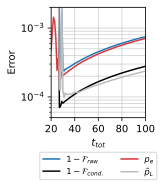

In [ ]:
fig = plt.figure(figsize=(1.7,2))
plt.plot(t_tot_array, raw_fidelity_arr,label = rf'$1-\mathcal{{F}}_{{raw}}$',color = '#1f77b4')
plt.plot(t_tot_array, conditional_computational_fidelity_arr,label = rf'$1-\mathcal{{F}}_{{cond.}}$',color='black')
plt.plot(t_tot_array, leak_to_g_arr,label = rf'$p_e$',color = "#d5373d")
plt.plot(t_tot_array, additional_leakage_arr,label = rf'$\tilde{{p}}_L$',color="#b9bbbd")
plt.yscale('log')
plt.ylim(5e-5,2e-3)
plt.xlabel(r'$t_{tot}$')
plt.ylabel(r'Error')
plt.xticks([20,40,60,80,100])
plt.xlim(20,100)
plt.grid(which='both', alpha=0.6)
plt.legend(bbox_to_anchor=(0.5, -0.6), loc='lower center',ncol = 2, fontsize='small')
plt.show()

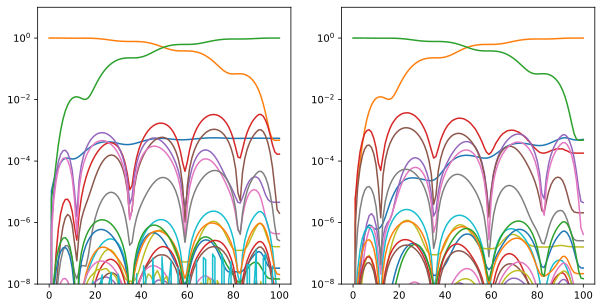

In [ ]:
t_tot = t_tot_array[23]
with open( f'evo_results/decay_evo_results_{t_tot}.pkl', 'rb') as f:
    results = pickle.load(f)
results = results[0]
fig, axes = plt.subplots(1,2,figsize = (10,5))
for i, exp in enumerate(results[0].expect):
    axes[0].plot(tlist,exp,label= f"{i}")
for i, exp in enumerate(results[1].expect):
    axes[1].plot(tlist,exp,label= f"{i}")
# axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_ylim(1e-8,1e1)
# axes[1].legend()
axes[1].set_yscale('log')
axes[1].set_ylim(1e-8,1e1)
plt.show()